# Process and Plot the Peak Historical Loads by Interconnection

This notebook analyzes the historical time series of extreme loads (summer and winter) by interconnection.

In [181]:
# Start by importing the packages we need:
import os

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from matplotlib import pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure

In [143]:
# Identify the data input and output directories:
load_data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/postprocessed/interconnection_load_time_series/'
temp_data_input_dir =  '/Volumes/LaCie/Big_Data/wrf_to_tell/wrf_tell_counties_output/historic/'
metadata_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL_Input_Data/tell_raw_data/County_Shapefiles/'
data_output_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/postprocessed/interconnection_load_time_series/'
image_output_dir =  '/Users/burl878/Documents/IMMM/Images/TELL/Analysis/Interconnection_Peak_Loads/'


## Process the Historical Peak Loads

In [118]:
# Define a function to process the time series of historical peak loads:
def process_historical_peak_loads(load_data_input_dir: str, data_output_dir: str, interconnection: str):
    # Read in the historical interconnection loads file:
    ics_df = pd.read_csv(load_data_input_dir + 'historic.csv')
    
    # Subset to just the data for the interconnection being processed:
    ics_df = ics_df.loc[ics_df['Interconnection'] == interconnection]
    
    # Rename some variables for simplicity:
    ics_df.rename(columns={'Interconnection_Load_MWh': 'Load_MWh', 'Percentile': 'Load_Percentile'}, inplace=True)
    
    # Set the time value as a datetime variable:
    ics_df['Datetime'] = pd.to_datetime(ics_df['Time_UTC'])
        
    # Add columns with the year and month values to be used in grouping:
    ics_df['Year'] = ics_df['Datetime'].dt.strftime('%Y').astype(str).astype(int)
    ics_df['Month'] = ics_df['Datetime'].dt.strftime('%m').astype(str).astype(int)
    
    # Compute the annual mean and standard deviation of the load:
    ics_df['Year_Mean_Load'] = ics_df.groupby('Year')['Load_MWh'].transform('mean').round(2)
    ics_df['Year_STD_Load'] = ics_df.groupby('Year')['Load_MWh'].transform('std').round(2)
    
    # Compute the hourly normalized load by subtracting the annual mean and dividing by the annual standard deviation:
    ics_df['Normalized_Load'] = ((ics_df['Load_MWh'] - ics_df['Year_Mean_Load']) / ics_df['Year_STD_Load']).round(2)
    
    # Subset to just the columns we need:
    ics_df = ics_df[['Time_UTC', 'Year', 'Month', 'Load_MWh', 'Normalized_Load', 'Year_Mean_Load']].copy()
    
    #Initiate a counter and empty dataframe to store the results:
    counter = 0;
    stats_df = pd.DataFrame()
    
    # Loop over the years and find the maximum summer and winter load in each year:
    for year in range(1980,2020,1):
        # Iterate the counter by one:
        counter = counter + 1 
        
        # Subset the data to just the year being processed and to just the summer and winter months:
        subset_df = ics_df.loc[(ics_df['Year'] == year)]
        #winter_df = subset_df.loc[(subset_df['Month'] == 1) | (subset_df['Month'] == 2) | (subset_df['Month'] == 3) | (subset_df['Month'] == 10) | (subset_df['Month'] == 11) | (subset_df['Month'] == 12)]
        #summer_df = subset_df.loc[(subset_df['Month'] == 4) | (subset_df['Month'] == 5) | (subset_df['Month'] == 6) | (subset_df['Month'] == 7) | (subset_df['Month'] == 8) | (subset_df['Month'] == 9)]
        winter_df = subset_df.loc[(subset_df['Month'] == 1) | (subset_df['Month'] == 2) | (subset_df['Month'] == 12)]
        summer_df = subset_df.loc[(subset_df['Month'] == 6) | (subset_df['Month'] == 7) | (subset_df['Month'] == 8)]
        
        # Find the row of the maximum load for each subset:
        all_max_index = subset_df['Load_MWh'].idxmax()
        winter_max_index = winter_df['Load_MWh'].idxmax()
        summer_max_index = summer_df['Load_MWh'].idxmax()
                
        # Put the statistics in a new dataframe:
        stats_df.loc[counter, 'Year'] = str(year)
        stats_df.loc[counter, 'Mean_Load_MWh'] = subset_df['Year_Mean_Load'].mean().round(2)
        stats_df.loc[counter, 'All_Max_Time'] = subset_df.loc[all_max_index, 'Time_UTC']
        stats_df.loc[counter, 'All_Max_Load_MWh'] = subset_df.loc[all_max_index, 'Load_MWh']
        stats_df.loc[counter, 'All_Max_Load_Norm'] = subset_df.loc[all_max_index, 'Normalized_Load']
        stats_df.loc[counter, 'Win_Max_Time'] = winter_df.loc[winter_max_index, 'Time_UTC']
        stats_df.loc[counter, 'Win_Max_Load_MWh'] = winter_df.loc[winter_max_index, 'Load_MWh']
        stats_df.loc[counter, 'Win_Max_Load_Norm'] = winter_df.loc[winter_max_index, 'Normalized_Load']
        stats_df.loc[counter, 'Sum_Max_Time'] = summer_df.loc[summer_max_index, 'Time_UTC']
        stats_df.loc[counter, 'Sum_Max_Load_MWh'] = summer_df.loc[summer_max_index, 'Load_MWh']
        stats_df.loc[counter, 'Sum_Max_Load_Norm'] = summer_df.loc[summer_max_index, 'Normalized_Load']

        # Clean up and move to the next year:
        del subset_df, winter_df, summer_df, all_max_index, winter_max_index, summer_max_index
        
    # Write out the time series dataframe to a .csv file:
    ics_df.to_csv((os.path.join(data_output_dir + interconnection + '_Peak_Load_Time_Series.csv')), sep=',', index=False)
    stats_df.to_csv((os.path.join(data_output_dir + interconnection + '_Peak_Load_Statistics.csv')), sep=',', index=False)
    
    return ics_df, stats_df


In [122]:
ts_df, stats_df = process_historical_peak_loads(load_data_input_dir = load_data_input_dir, 
                                                data_output_dir = data_output_dir, 
                                                interconnection = 'WECC')

stats_df


,Year,Mean_Load_MWh,All_Max_Time,All_Max_Load_MWh,All_Max_Load_Norm,Win_Max_Time,Win_Max_Load_MWh,Win_Max_Load_Norm,Sum_Max_Time,Sum_Max_Load_MWh,Sum_Max_Load_Norm
1,1980,30914.57,1980-07-28 01:00:00,49354.14,4.24,1980-01-29 04:00:00,40135.12,2.12,1980-07-28 01:00:00,49354.14,4.24
2,1981,34288.05,1981-08-07 01:00:00,52510.30,3.71,1981-12-24 03:00:00,41388.38,1.45,1981-08-07 01:00:00,52510.30,3.71
3,1982,37573.28,1982-09-03 00:00:00,56159.95,3.67,1982-01-07 03:00:00,48504.08,2.16,1982-08-23 00:00:00,55991.09,3.64
4,1983,40843.36,1983-08-08 01:00:00,64112.88,4.13,1983-12-22 03:00:00,52777.76,2.12,1983-08-08 01:00:00,64112.88,4.13
5,1984,44007.92,1984-08-09 01:00:00,66528.09,3.61,1984-01-19 03:00:00,55326.52,1.82,1984-08-09 01:00:00,66528.09,3.61
6,1985,47399.02,1985-07-09 01:00:00,76729.13,4.39,1985-02-05 03:00:00,59361.03,1.79,1985-07-09 01:00:00,76729.13,4.39
7,1986,50678.95,1986-08-20 00:00:00,76601.63,3.70,1986-12-11 03:00:00,61380.81,1.53,1986-08-20 00:00:00,76601.63,3.70
8,1987,53960.87,1987-08-05 01:00:00,80905.86,3.68,1987-01-16 04:00:00,66783.79,1.75,1987-08-05 01:00:00,80905.86,3.68
9,1988,57072.15,1988-07-26 01:00:00,88757.64,3.87,1988-12-27 03:00:00,72163.87,1.84,1988-07-26 01:00:00,88757.64,3.87
10,1989,60522.61,1989-07-20 01:00:00,95155.04,4.16,1989-02-03 04:00:00,79807.79,2.32,1989-07-20 01:00:00,95155.04,4.16


In [127]:
# Define a function to plot the time series of extreme loads by interconnection
def plot_historical_peak_loads(interconnection: str, data_output_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Check to see if the output already exist and if not then process it:
    if os.path.isfile((os.path.join(data_output_dir + interconnection + '_Peak_Load_Time_Series.csv'))) == True:
       # Load in the pre-processed data:
       ts_df = pd.read_csv((os.path.join(data_output_dir + interconnection + '_Peak_Load_Time_Series.csv')))
       stats_df = pd.read_csv((os.path.join(data_output_dir + interconnection + '_Peak_Load_Statistics.csv')))
    else:
       ts_df, stats_df = process_historical_peak_loads(load_data_input_dir = load_data_input_dir, 
                                                       data_output_dir = data_output_dir, 
                                                       interconnection = 'WECC')
    
    # Find the four highest values:
    winter_peak_raw = stats_df.nlargest(4, 'Win_Max_Load_MWh')
    winter_peak_norm = stats_df.nlargest(4, 'Win_Max_Load_Norm')
    summer_peak_raw = stats_df.nlargest(4, 'Sum_Max_Load_MWh')
    summer_peak_norm = stats_df.nlargest(4, 'Sum_Max_Load_Norm')
    
    max_times = pd.concat([winter_peak_norm['Win_Max_Time'],summer_peak_norm['Sum_Max_Time']])
    #gcam_usa_output_df = pd.concat([gcam_usa_output_df, state_df])
    
    # Make the plot:
    plt.figure(figsize=(24, 15))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(211)
    plt.plot(stats_df['Year'], stats_df['Win_Max_Load_MWh'], color='b', linestyle='-', label='Winter Peak Load', linewidth=3)
    plt.plot(stats_df['Year'], stats_df['Sum_Max_Load_MWh'], color='r', linestyle='-', label='Summer Peak Load', linewidth=3)
    plt.scatter(winter_peak_raw['Year'], winter_peak_raw['Win_Max_Load_MWh'], s=100, c='blue')
    plt.scatter(summer_peak_raw['Year'], summer_peak_raw['Sum_Max_Load_MWh'], s=100, c='red')
    plt.xlim([1979, 2020]); 
    plt.grid(True)
    plt.legend(loc='upper left', prop={'size': 14})
    plt.ylabel('Total Interconnection Load [MWh]')
    plt.title((interconnection + ' Interconnection Peak Loads: 1980-2019'))
    
    plt.subplot(212)
    plt.plot(stats_df['Year'], stats_df['Win_Max_Load_Norm'], color='b', linestyle='-', label='Winter Peak Load', linewidth=3)
    plt.plot(stats_df['Year'], stats_df['Sum_Max_Load_Norm'], color='r', linestyle='-', label='Summer Peak Load', linewidth=3)
    plt.scatter(winter_peak_norm['Year'], winter_peak_norm['Win_Max_Load_Norm'], s=100, c='blue')
    plt.scatter(summer_peak_norm['Year'], summer_peak_norm['Sum_Max_Load_Norm'], s=100, c='red')
    plt.xlim([1979, 2020]); 
    plt.grid(True)
    plt.xlabel('Year');
    plt.ylabel('Annually Normalized Total Interconnection Load')
    plt.title(('Normalized Peak Loads'))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (interconnection + '_Peak_Load_Time_Series.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
    
    return max_times
                      

9     1989-02-03 04:00:00
10    1990-12-22 03:00:00
2     1982-01-07 03:00:00
0     1980-01-29 04:00:00
26    2006-07-24 01:00:00
13    1993-08-02 01:00:00
5     1985-07-09 01:00:00
30    2010-07-16 01:00:00
dtype: object

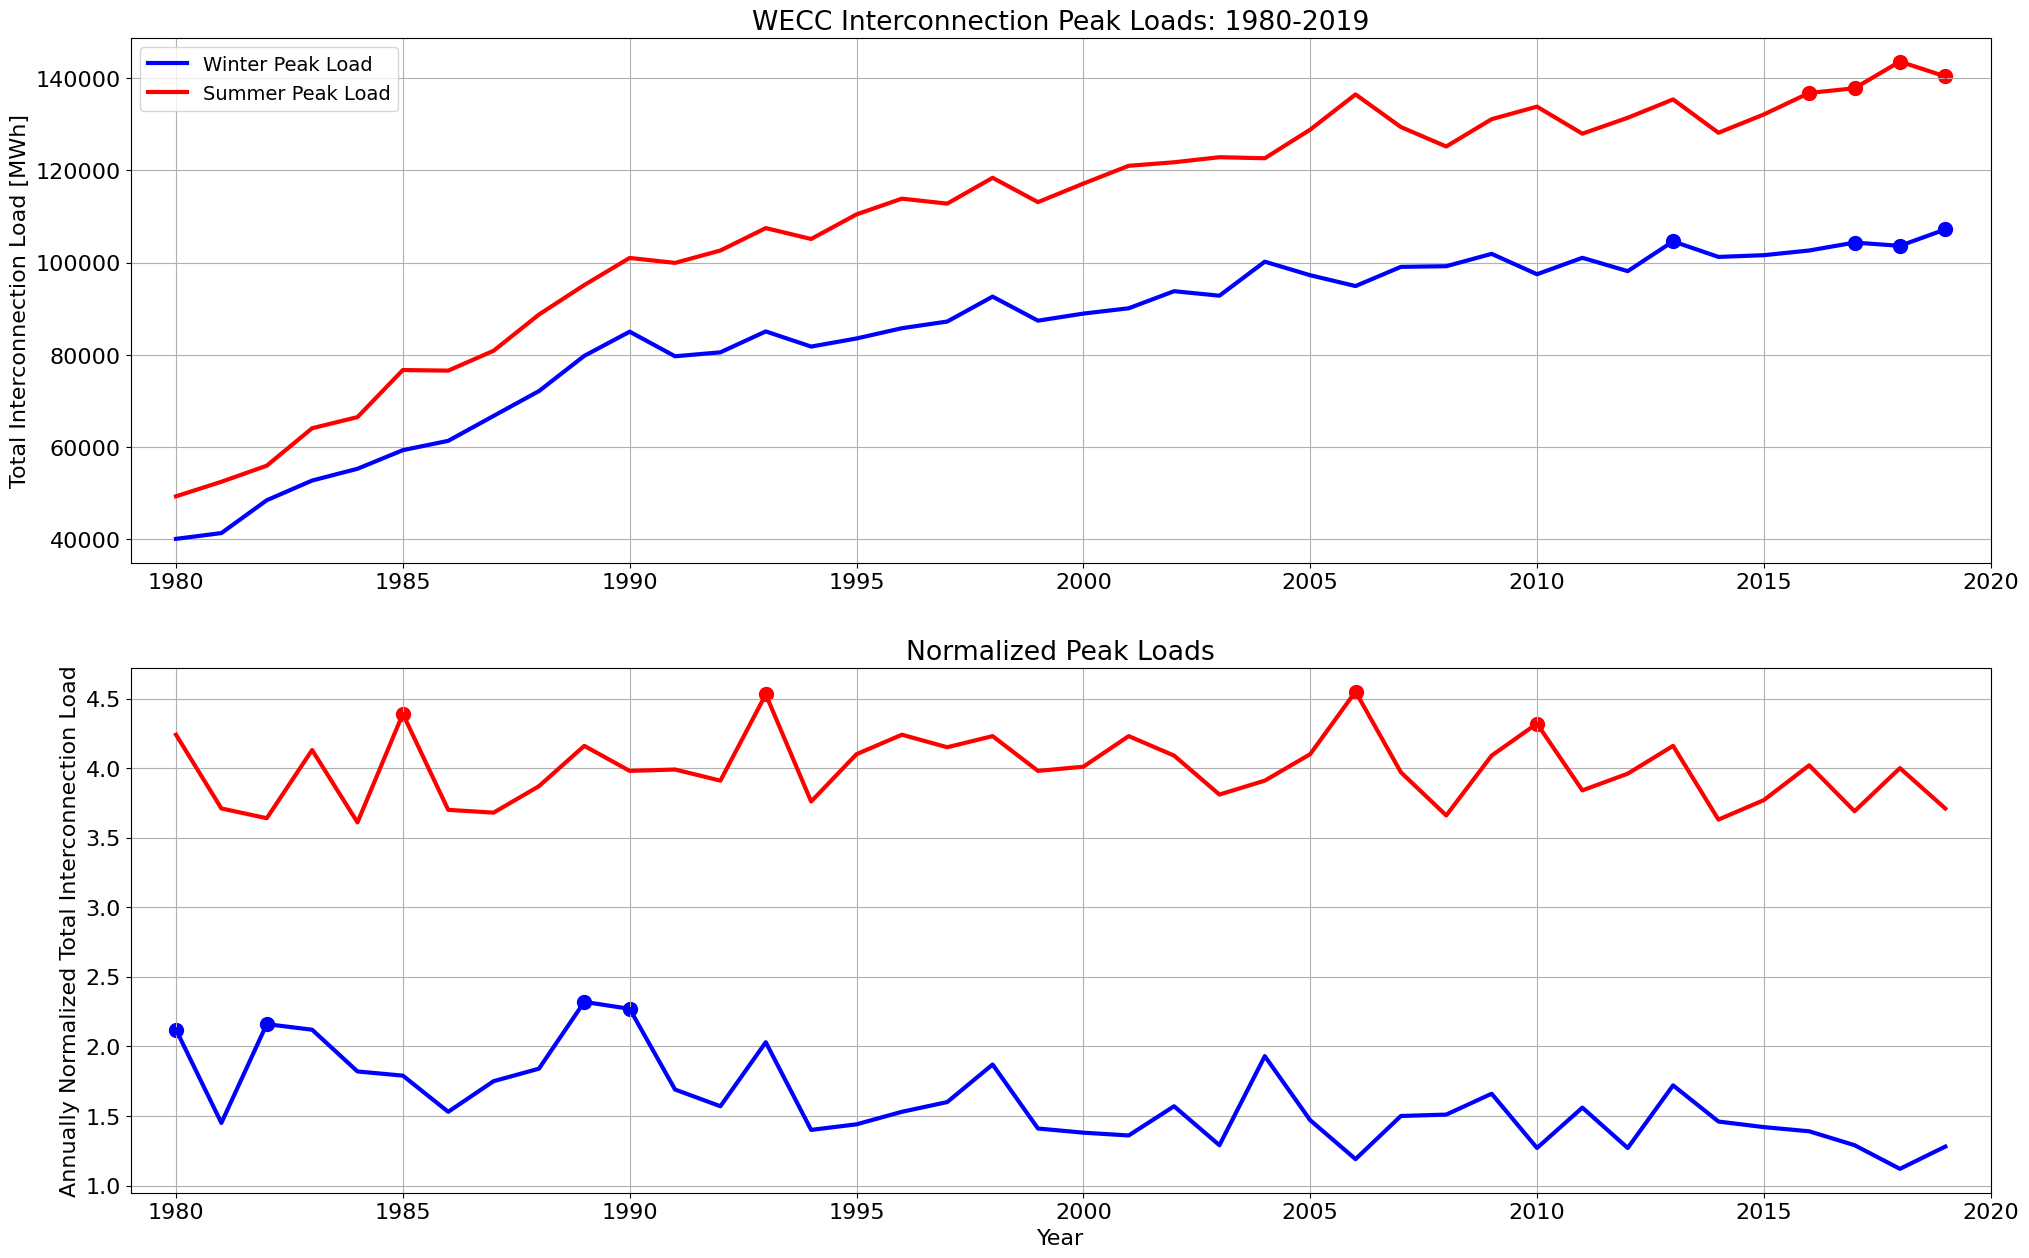

In [134]:
max_times = plot_historical_peak_loads(interconnection = 'WECC',
                                       data_output_dir = data_output_dir,
                                       image_output_dir = image_output_dir, 
                                       image_resolution = 300, 
                                       save_images = True)

max_times


In [237]:
# Define a function to plot the temperature during extreme load events:
def plot_peak_load_temperatures(interconnection: str, metadata_input_dir: str, temp_data_input_dir: str, data_output_dir: str, image_output_dir: str, image_resolution: int, save_images=False):

    # Read in the county shapefile and reassign the 'FIPS' variable as integers:
    counties_df = gpd.read_file(os.path.join(metadata_input_dir, r'tl_2020_us_county.shp')).rename(columns={'GEOID': 'FIPS'})
    counties_df['FIPS'] = counties_df['FIPS'].astype(int)
    
    if interconnection == 'WECC':
       cold1_temp = pd.read_csv((os.path.join(temp_data_input_dir + '1989/' + '1989_02_03_04_UTC_County_Mean_Meteorology.csv')))
       cold1_temp['T2'] = (1.8 * (cold1_temp['T2'] - 273)) + 32
       cold1_label = 'WECC Winter Peak One: 3-Feb 1989 0400 UTC'
       cold2_temp = pd.read_csv((os.path.join(temp_data_input_dir + '1990/' + '1990_12_22_03_UTC_County_Mean_Meteorology.csv')))
       cold2_temp['T2'] = (1.8 * (cold2_temp['T2'] - 273)) + 32
       cold2_label = 'WECC Winter Peak Two: 22-Dec 1990 0300 UTC'
       cold3_temp = pd.read_csv((os.path.join(temp_data_input_dir + '1982/' + '1982_01_07_03_UTC_County_Mean_Meteorology.csv')))
       cold3_temp['T2'] = (1.8 * (cold3_temp['T2'] - 273)) + 32
       cold3_label = 'WECC Winter Peak Three: 7-Jan 1982 0300 UTC'
       cold4_temp = pd.read_csv((os.path.join(temp_data_input_dir + '1980/' + '1980_01_29_04_UTC_County_Mean_Meteorology.csv')))
       cold4_temp['T2'] = (1.8 * (cold4_temp['T2'] - 273)) + 32
       cold4_label = 'WECC Winter Peak Four: 29-Jan 1980 0400 UTC'
    
       warm1_temp = pd.read_csv((os.path.join(temp_data_input_dir + '2006/' + '2006_07_24_01_UTC_County_Mean_Meteorology.csv')))
       warm1_temp['T2'] = (1.8 * (warm1_temp['T2'] - 273)) + 32
       warm1_label = 'WECC Summer Peak One: 24-Jul 2006 0100 UTC'
       warm2_temp = pd.read_csv((os.path.join(temp_data_input_dir + '1993/' + '1993_08_02_01_UTC_County_Mean_Meteorology.csv')))
       warm2_temp['T2'] = (1.8 * (warm2_temp['T2'] - 273)) + 32
       warm2_label = 'WECC Summer Peak Two: 2-Aug 1993 0100 UTC'
       warm3_temp = pd.read_csv((os.path.join(temp_data_input_dir + '1985/' + '1985_07_09_01_UTC_County_Mean_Meteorology.csv')))
       warm3_temp['T2'] = (1.8 * (warm3_temp['T2'] - 273)) + 32
       warm3_label = 'WECC Summer Peak Three: 9-Jul 1985 0100 UTC'
       warm4_temp = pd.read_csv((os.path.join(temp_data_input_dir + '2010/' + '2010_07_16_01_UTC_County_Mean_Meteorology.csv')))
       warm4_temp['T2'] = (1.8 * (warm4_temp['T2'] - 273)) + 32
       warm4_label = 'WECC Summer Peak Four: 16-Jul 2010 0100 UTC'
    
    # Merge the ba_mapping_df and counties_df together using county FIPS codes to join them:
    cold1_df = counties_df.merge(cold1_temp, on='FIPS', how='left')
    cold2_df = counties_df.merge(cold2_temp, on='FIPS', how='left')
    cold3_df = counties_df.merge(cold3_temp, on='FIPS', how='left')
    cold4_df = counties_df.merge(cold4_temp, on='FIPS', how='left')
    
    warm1_df = counties_df.merge(warm1_temp, on='FIPS', how='left')
    warm2_df = counties_df.merge(warm2_temp, on='FIPS', how='left')
    warm3_df = counties_df.merge(warm3_temp, on='FIPS', how='left')
    warm4_df = counties_df.merge(warm4_temp, on='FIPS', how='left')
    
    
    # Create the cold event figure:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,10))
    ax1 = cold1_df.plot(ax=axes[0, 0], column='T2', cmap='RdYlBu_r', vmin=-45, vmax=75, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
    ax1.set_title(cold1_label)
    ax2 = cold2_df.plot(ax=axes[0, 1], column='T2', cmap='RdYlBu_r', vmin=-45, vmax=75, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
    ax2.set_title(cold2_label)
    ax3 = cold3_df.plot(ax=axes[1, 0], column='T2', cmap='RdYlBu_r', vmin=-45, vmax=75, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
    ax3.set_title(cold3_label)
    ax4 = cold4_df.plot(ax=axes[1, 1], column='T2', cmap='RdYlBu_r', vmin=-45, vmax=75, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
    ax4.set_title(cold4_label)
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (interconnection + '_Winter_Peak_Maps.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
    
    # Create the hot event figure:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,10))
    ax1 = warm1_df.plot(ax=axes[0, 0], column='T2', cmap='RdYlBu_r', vmin=45, vmax=115, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
    ax1.set_title(warm1_label)
    ax2 = warm2_df.plot(ax=axes[0, 1], column='T2', cmap='RdYlBu_r', vmin=45, vmax=115, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
    ax2.set_title(warm2_label)
    ax3 = warm3_df.plot(ax=axes[1, 0], column='T2', cmap='RdYlBu_r', vmin=45, vmax=115, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
    ax3.set_title(warm3_label)
    ax4 = warm4_df.plot(ax=axes[1, 1], column='T2', cmap='RdYlBu_r', vmin=45, vmax=115, edgecolor='grey', linewidth=0.2, legend=True, legend_kwds={'label': ('Temperature ($^\circ$F)'), 'orientation': 'vertical'})
    ax4.set_title(warm4_label)
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = (interconnection + '_Summer_Peak_Maps.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
    

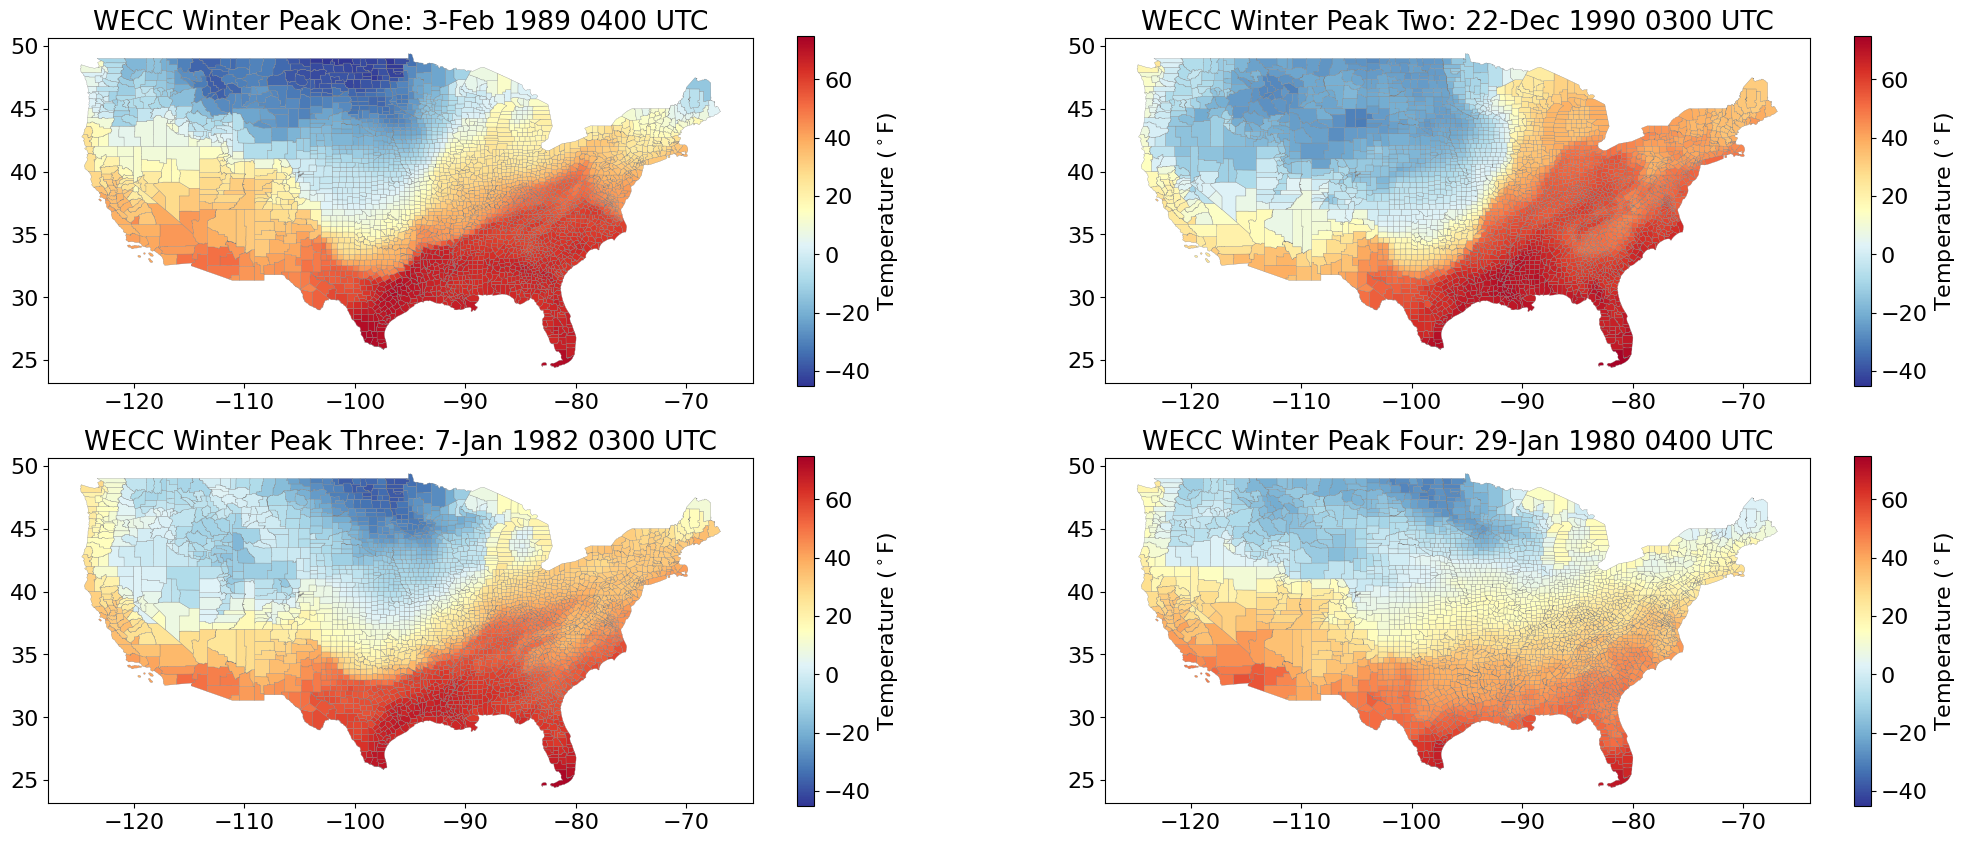

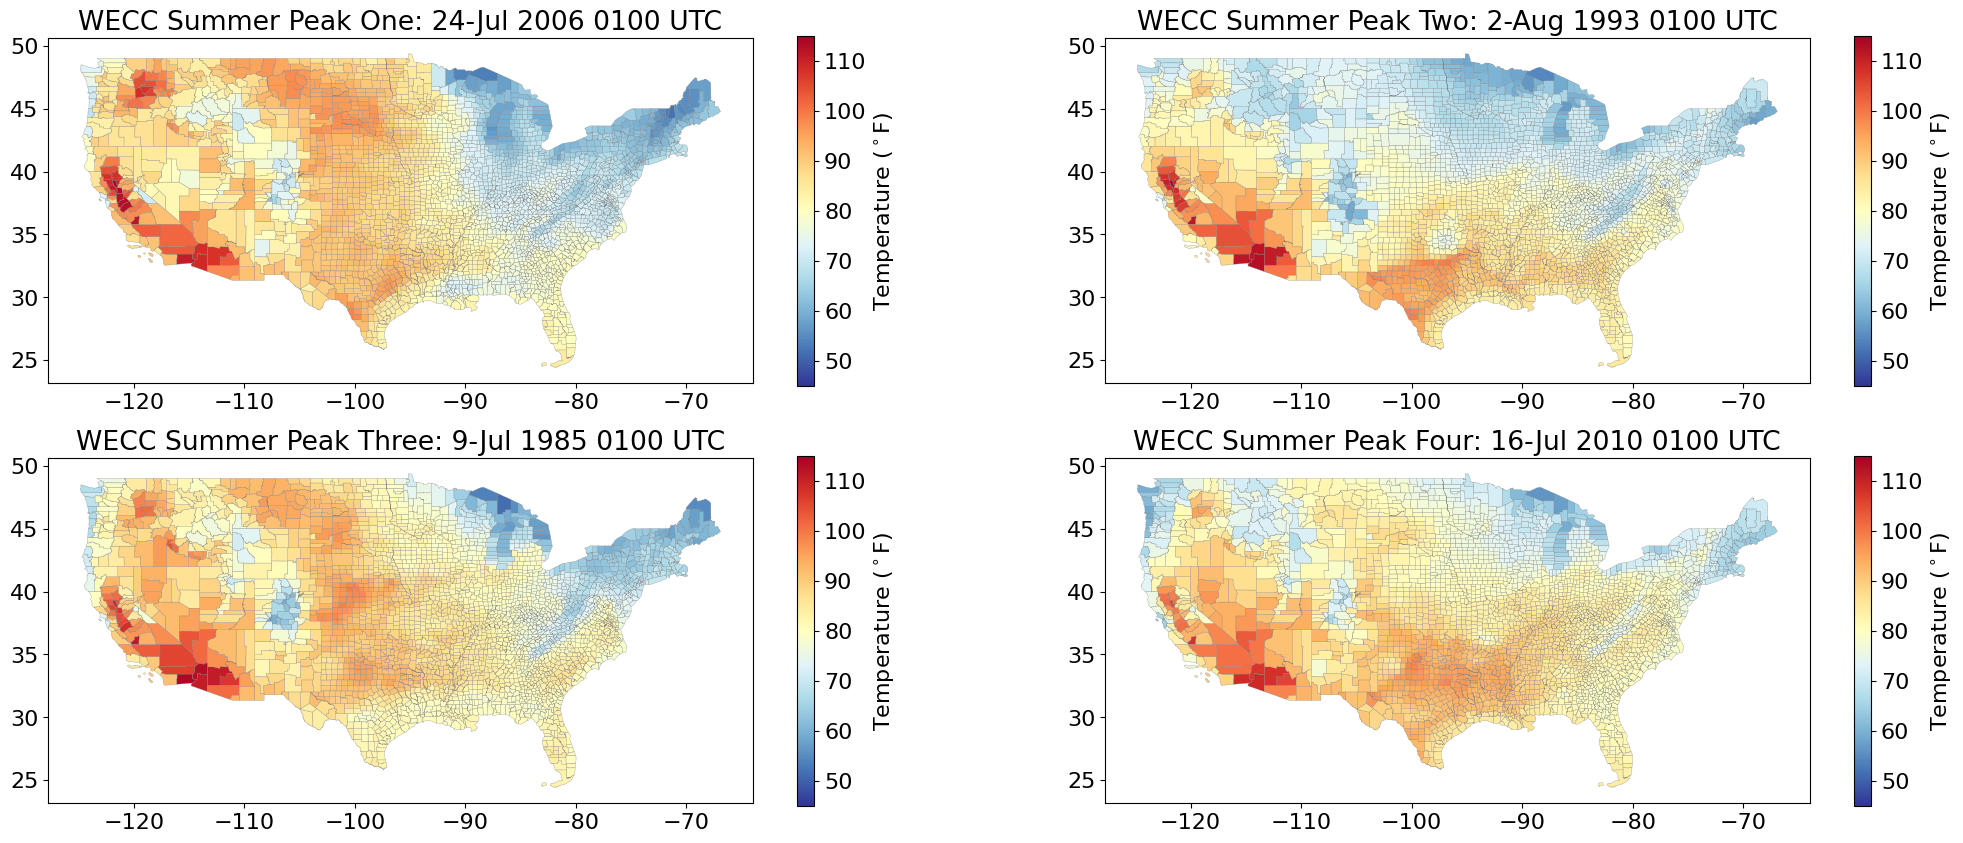

In [238]:
plot_peak_load_temperatures(interconnection = 'WECC',
                            metadata_input_dir = metadata_input_dir,
                            temp_data_input_dir = temp_data_input_dir,
                            data_output_dir = data_output_dir,
                            image_output_dir = image_output_dir, 
                            image_resolution = 300, 
                            save_images = True)
